[View in Colaboratory](https://colab.research.google.com/github/shrestha-pranav/2048-AI/blob/master/Deep_Learning_HW1.ipynb)

# HW1

Jeffrey Wan (jw3468)

Pranav Shrestha(ps2958)

# Part 1
Fully Connected Neural Network From Scratch

## Environment setup

In [0]:
# Installing PyTorch
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision

In [0]:
import torch, torchvision
import numpy as np

In [3]:
# CIFAR 10 dataset
transform = torchvision.transforms.Compose(
              [torchvision.transforms.ToTensor(),
              torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataparams = dict(root='./data', download=True, transform=transform)
trainset   = torchvision.datasets.CIFAR10(train=True, **dataparams)
testset    = torchvision.datasets.CIFAR10(train=False, **dataparams)
len(trainset), len(testset)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

## Splitting data

In [4]:
numtrain = len(trainset)
indices  = list(range(numtrain))
split    = int(0.1 * numtrain)

valididx = np.random.choice(indices, size=split, replace=False)
trainidx = set(indices) - set(valididx)

print(len(valididx), len(trainidx))

valid_X = []
valid_y = []
train_X = []
train_y = []

for i, (X, y) in enumerate(trainset):
    X = X.numpy().ravel()
    y = int(y)
    if i in trainidx:
        train_X.append(X)
        train_y.append(y)
    else:
        valid_X.append(X)
        valid_y.append(y)

5000 45000


## Activation functions

In [0]:
def softmax(X):
    return np.array([stable_softmax(x) for x in X])

def stable_softmax(X):
    exps = np.exp(X - np.max(X))
    return exps / np.sum(exps)

# ReLU function and it's derivative
dReLU = lambda X: (X>0).astype(int)
ReLU  = lambda X: np.maximum(0, X)

## NeuralNetwork Implementation

In [0]:
class NeuralNetwork:
    """ Implementation for a Fully Connection Neural Network """

    def __init__(self, layer_dimensions):
        """ Randomly initialize weights and biases based on layer_dimensions """
        self.num_layers = len(layer_dimensions)

        self.Ws = [
            np.random.random((layer_dimensions[i], layer_dimensions[i+1]))/100
            for i in range(self.num_layers-1)]
        
        self.bs = [
            np.random.random(layer_dimensions[i+1])/100 
            for i in range(self.num_layers-1)]
        
        print ("Initialized random weights : ", [i.shape for i in self.Ws])
        print ("Initialized random biases  : ", [i.shape for i in self.bs])

    def affineForward(self, A, W, b):
        """ Returns z_l = A_l * W_l + b_l"""
        # zn = A (batch_size x in_dim) x W (in_dim x out_dim)
        zn = np.matmul(A, W)

        # (batch_size x out_dim) + (1 x out_dim).broadcast(batch_size)
        return zn + b


    def activationForward(self, A):
        """ Applies the activation function. Returns a_l = sigma(z_l) """
        return ReLU(A)

    def forwardPropagation(self, X):
        # History of activation output a_ls for every layer l
        a_l = [X]
        for n in range(self.num_layers - 1):
            # zn = A (batch_size x in_dim) x W (in_dim x out_dim)
            zn = self.affineForward(a_l[n], self.Ws[n], self.bs[n])

            # ReLU activation on all layers, except the last one
            an = self.activationForward(zn) if n<self.num_layers-2 else zn
            
            a_l.append(an)
        return a_l

    def costFunction(self, AL, y):
        """
        Returns cross entropy cost function and its gradient
        Cost function is scalar. Sum of all costs
        Gradient is batch_size x num_classes
        """
        
        m = y.shape[0]

        p = softmax(AL)
        log_likelihood = np.log(p[range(m), y])
        loss = - np.sum(log_likelihood) / m

        p[range(m),y] -= 1
        p = p / m

        return loss, p

    def affineBackward(self, dA_prev, cache):
        # dA_prev (batch_size x out_dim)
        # cache = Weight matrix (in_dim x out_dim)
        return np.matmul(dA_prev, cache.T)

    def activationBackward(self, dA, cache):
        return dA * dReLU(cache)

    # TODO: Remove Y from parameters
    def backPropagation(self, dAL, Y, cache):
        """ Back propagates errors for weight/bias gradient descent """

        n_layers = self.num_layers - 1 # number of weighted layers
        
        dZs = [0] * n_layers 
        dZs[-1] = dAL # (b, 10)

        # dZ_{i-1} = dZ_i * W_i^T * dReLU(a_l_i)
        for i in range(n_layers-2, -1, -1):
            dA = self.affineBackward(dZs[i+1], self.Ws[i+1])
            dZ = self.activationBackward(dA, cache[i+1])

            dZs[i] = dZ

        # Update weights dW_i = a_l_i^T * dZ_i
        # Update biases  dB_i = dZ_i
        dWs = [np.matmul(cache[n].T, dZs[n]) for n in range(n_layers)]
        dbs = [np.sum(i, 0) for i in dZs]
        
        return dWs, dbs

    def updateParameters(self, gradients, alpha):
        """ Updates weights and biases given the gradients and learning rate """
        dWs, dbs = gradients
        for i in range(self.num_layers - 1):
            self.Ws[i] = self.Ws[i] - dWs[i] * alpha
            self.bs[i] = self.bs[i] - dbs[i] * alpha

    def train(self, X_train, X_val, y_train, y_val, iters, alpha, batch_size):
        print("\nTraining for {} epoch(s) with batch_size {} and learning_rate {}".format(
            iters, batch_size, alpha
        ))
    
        # split into data into batches of batch_size
        total_samples = len(X_train)
        n_batches = total_samples // batch_size
        Xs = [np.array(X_train[i * batch_size : (i+1) * batch_size]) for i in range(n_batches)]
        ys = [np.array(y_train[i * batch_size : (i+1) * batch_size]) for i in range(n_batches)]
        
        for it in range(iters):
            for n in range(len(Xs)):
                X, y = Xs[n], ys[n]
                
                a_l = self.forwardPropagation(X) # updates outs
                
                cost, dAL = self.costFunction(a_l[-1], y) # Backpropagate
                dWs, dbs = self.backPropagation(dAL, None, a_l)
                
                self.updateParameters((dWs, dbs), alpha) # Update weights

            print("Epoch [{:2d}/{:2d}] Cost: {:0.5f} "
                "Training accuracy: {:2.3f}% "
                "Validation accuracy: {:2.3f}%".format(
                it+1, iters, cost,
                100*self.getPredictionAccuracy(X_train, y_train), 
                100*self.getPredictionAccuracy(X_val, y_val),
            ))
    
    def getPredictionAccuracy(self, X_new, y_new):
        """ Helper function to return prediction accuracy on arbitrary dataset """
        X_new, y_new = np.array(X_new), np.array(y_new)
        if len(X_new) != len(y_new):
            raise ValueError("Input data and labels need to be same dimension")

        return np.sum(self.predict(X_new) == y_new) / len(y_new)

    def predict(self, X_new):
        """ Returns predicted labels for each datapoint in X_new """
        a_l = self.forwardPropagation(X_new)
        return np.argmax(a_l[-1], axis=1)

## Training and Validation

In [7]:
n = NeuralNetwork([3072, 512, 10])
n.train(train_X, valid_X, train_y, valid_y, 20, 0.01, 32)

Initialized random weights :  [(3072, 512), (512, 10)]
Initialized random biases  :  [(512,), (10,)]

Training for 20 epoch(s) with batch_size 32 and learning_rate 0.01
Epoch [ 1/20] Cost: 2.39373 Training accuracy: 23.800% Validation accuracy: 24.420%
Epoch [ 2/20] Cost: 1.96775 Training accuracy: 32.267% Validation accuracy: 32.960%
Epoch [ 3/20] Cost: 1.80733 Training accuracy: 38.289% Validation accuracy: 37.900%
Epoch [ 4/20] Cost: 1.75587 Training accuracy: 41.558% Validation accuracy: 40.760%
Epoch [ 5/20] Cost: 1.75465 Training accuracy: 44.171% Validation accuracy: 42.800%
Epoch [ 6/20] Cost: 1.73619 Training accuracy: 45.940% Validation accuracy: 43.620%
Epoch [ 7/20] Cost: 1.69448 Training accuracy: 47.438% Validation accuracy: 44.800%
Epoch [ 8/20] Cost: 1.65975 Training accuracy: 48.709% Validation accuracy: 45.660%
Epoch [ 9/20] Cost: 1.63373 Training accuracy: 50.071% Validation accuracy: 46.380%
Epoch [10/20] Cost: 1.60764 Training accuracy: 51.182% Validation accuracy:

## Prediction Output

In [8]:
test_X = [X.numpy().ravel() for (X,y) in testset]
test_y = testset.test_labels

testacc = n.getPredictionAccuracy(test_X, test_y)
print("Testing accuracy : %2.3f%%" % (100 * testacc))

Testing accuracy : 51.190%


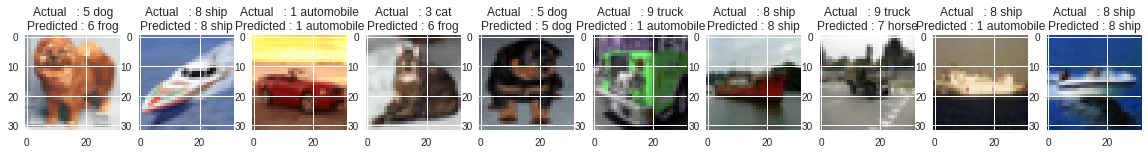

In [9]:
import matplotlib.pyplot as plt
labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

def imshow(imgs, labels=None):
    n = len(imgs)
    fig, axs = plt.subplots(1, n, figsize=(20, 10))
    
    for i in range(n):
        ax = axs[i]
        img = imgs[i] / 2 + 0.5
        npimg = img.numpy()
        ax.imshow(np.transpose(npimg, (1,2,0)))
        if labels:
            ax.set_title(labels[i])

imgidx = np.random.randint(len(testset), size=10, dtype=int)

test_images = [testset[i][0] for i in imgidx]
test_labels = ["%d %s"%(test_y[i], labels[test_y[i]]) for i in imgidx]

ravel_imgs = [img.numpy().ravel() for img in test_images]
predicted_labels = n.predict(ravel_imgs)
predicted_labels = ["%d %s"%(i, labels[i]) for i in predicted_labels]

imglbls = ["Actual   : %s\nPredicted : %s"%(test_labels[i], predicted_labels[i]) for i in range(10)]
imshow(test_images, imglbls)

# Part 2
CNN Using PyTorch

## Environment Setup

In [0]:
# Installing PyTorch
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision

In [0]:
import torch, torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

In [12]:
# CIFAR 10 dataset
transform = torchvision.transforms.Compose(
              [torchvision.transforms.ToTensor(),
              torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataparams = dict(root='./data', download=True, transform=transform)
trainset   = torchvision.datasets.CIFAR10(train=True, **dataparams)
testset    = torchvision.datasets.CIFAR10(train=False, **dataparams)
len(trainset), len(testset)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

In [13]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Manual seed for reproducibility
seed = 10
np.random.seed(seed)
torch.manual_seed(seed)

## Test Scripts

In [0]:
# Split into validation set
def split_data(trainset, testset, batch_size, split=5000):
    numtrain = len(trainset)
    indices  = list(range(numtrain))

    valididx = np.random.choice(indices, size=split, replace=False)
    trainidx = list(set(indices) - set(valididx))

    trainsmplr = SubsetRandomSampler(trainidx)
    validsmplr = SubsetRandomSampler(valididx)

    loader_props = dict(batch_size=batch_size)
    train_loader = torch.utils.data.DataLoader(trainset, sampler=trainsmplr, **loader_props)
    valid_loader = torch.utils.data.DataLoader(trainset, sampler=validsmplr, **loader_props)
    test_loader  = torch.utils.data.DataLoader(testset, **loader_props)

    print("Training set: {1:}x{0:}\tValidation set: {2:}x{0:}\tTesting set:{3:}".format(
        batch_size, len(train_loader), len(valid_loader), len(test_loader)
    ))
    
    return train_loader, valid_loader, test_loader

In [0]:
# Test the model
def getAccuracy(model, dataloader):
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / float(total)

In [0]:
num_classes=10 # CIFAR10 preset

def trainModel(modelclass, num_epochs=20, batch_size=250, learning_rate=0.05):
    print("\nTraining for {} epoch(s) with batch_size {} and learning_rate {}".format(
        num_epochs, batch_size, learning_rate
    ))
    model = modelclass(num_classes).to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss() # Includes SoftMax and LogLikelihood Loss
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    # Train the model
    train_loader, valid_loader, test_loader = split_data(trainset, testset, batch_size)

    total_step = len(train_loader)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        train_acc = getAccuracy(model, train_loader)
        valid_acc = getAccuracy(model, valid_loader)
        print ("Epoch [{:2d}/{:2d}] Loss: {:.4f} "
            "Training Accuracy: {:.3f}% Validation Accuracy: {:3f}%".format(
            epoch+1, num_epochs, loss.item(),
            100*train_acc, 100*valid_acc))

    print("\nTesting Accuracy: {:.3f}%".format(
        100*getAccuracy(model, test_loader)
    ))
    return model

## Version 1

- Convolution Layer with BatchNorm, ReLU, MaxPool
- Convolution Layer with BatchNorm, ReLU, MaxPool
- Fully connected Layer size 1024 with ReLU
- Fully connected Layer size 256 with ReLU
- Fully connected Layer size 64 with ReLU
- Fully connected Layer size 10 with SoftMax


In [0]:
class ConvNet1(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet1, self).__init__()

        # Input dimension = 32x32x3
        # Output dimension = 16x16x16
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(8*8*64, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 10)   
        )
        
    def forward(self, x):
        # 2 convolution layers, with BatchNorm, ReLU and Maxpooling
        out = self.layer1(x)
        out = self.layer2(out)
        
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)

        return out

In [18]:
model1 = trainModel(ConvNet1, num_epochs=20, batch_size=250, learning_rate=0.05)


Training for 20 epoch(s) with batch_size 250 and learning_rate 0.05
Training set: 180x250	Validation set: 20x250	Testing set:40
Epoch [ 1/20] Loss: 1.3515 Training Accuracy: 56.967% Validation Accuracy: 55.800000%
Epoch [ 2/20] Loss: 0.9683 Training Accuracy: 67.987% Validation Accuracy: 63.320000%
Epoch [ 3/20] Loss: 0.7842 Training Accuracy: 75.869% Validation Accuracy: 68.140000%
Epoch [ 4/20] Loss: 0.7099 Training Accuracy: 82.136% Validation Accuracy: 70.100000%
Epoch [ 5/20] Loss: 0.5838 Training Accuracy: 87.864% Validation Accuracy: 70.100000%
Epoch [ 6/20] Loss: 0.4749 Training Accuracy: 89.920% Validation Accuracy: 69.100000%
Epoch [ 7/20] Loss: 0.3428 Training Accuracy: 94.502% Validation Accuracy: 70.920000%
Epoch [ 8/20] Loss: 0.2024 Training Accuracy: 95.889% Validation Accuracy: 70.460000%
Epoch [ 9/20] Loss: 0.1581 Training Accuracy: 96.827% Validation Accuracy: 70.380000%
Epoch [10/20] Loss: 0.1565 Training Accuracy: 97.667% Validation Accuracy: 70.360000%
Epoch [11/2

## Version 2

In this version of the model, we use the same Conv-BN-ReLU-MaxPool structure but add an additional convolutional layer.

In this version, we aim to see whether the additional convolution layer will improve classification. We hypothesize that having this additonal layer of convolution allows the model to learn more higher level features. Hence, using these higher level features facilitate the ability of the final 3 fully connected layers to perform classification.

In version1, training accuracy approaches 1, which means it is clearly overfitting. So, we also added dropout, which randomly drops out units to prevent complex co-adaptations on training data. This reduces the overfitting and gives higher validation accuracy. Combined with BatchNorm, it didn't give us good results. This might be due to disharmony [as documented](https://arxiv.org/abs/1801.05134)

After testing the model, we see that the new model increases both training and testing accuracy but not significantly. The increase in performance is lower than we thought perhaps because the first two convolutional layers are already able to learn the necessary high level features in order to identify the image. Although the additional convolutional layer reduces the bias of the model it must also increase the variation. We think a more complex model might show a greater increase in performance if more training data is available.

The model still gave ~97% training accuracy. For our last optimization, we tried reducing the fully connected layer to reduce overfitting further. This too didn't seem to help enough to be significant. We are still trying other methods.

In [0]:
class ConvNet2(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet2, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(4*4*64, 512),
            nn.ReLU(),
            nn.Linear(512, 10)   
        )
        
    def forward(self, x):
        # 2 convolution layers, with BatchNorm, ReLU and Maxpooling
        out = self.cnn(x)
        
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)

        return out

In [26]:
model2 = trainModel(ConvNet1, num_epochs=20, batch_size=250, learning_rate=0.05)


Training for 20 epoch(s) with batch_size 250 and learning_rate 0.05
Training set: 180x250	Validation set: 20x250	Testing set:40
Epoch [ 1/20] Loss: 1.2036 Training Accuracy: 58.984% Validation Accuracy: 57.880000%
Epoch [ 2/20] Loss: 1.0511 Training Accuracy: 63.582% Validation Accuracy: 61.280000%
Epoch [ 3/20] Loss: 0.9111 Training Accuracy: 72.578% Validation Accuracy: 66.800000%
Epoch [ 4/20] Loss: 0.7273 Training Accuracy: 79.113% Validation Accuracy: 68.520000%
Epoch [ 5/20] Loss: 0.8318 Training Accuracy: 82.938% Validation Accuracy: 68.340000%
Epoch [ 6/20] Loss: 0.5193 Training Accuracy: 90.398% Validation Accuracy: 69.560000%
Epoch [ 7/20] Loss: 0.3834 Training Accuracy: 92.971% Validation Accuracy: 70.260000%
Epoch [ 8/20] Loss: 0.2400 Training Accuracy: 95.844% Validation Accuracy: 70.760000%
Epoch [ 9/20] Loss: 0.1973 Training Accuracy: 96.191% Validation Accuracy: 69.680000%
Epoch [10/20] Loss: 0.1396 Training Accuracy: 97.484% Validation Accuracy: 70.740000%
Epoch [11/2

## Output Visualization

In [0]:
import matplotlib.pyplot as plt
labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

def imshow(imgs, labels=None):
    n = len(imgs)
    fig, axs = plt.subplots(1, n, figsize=(20, 10))

    for i in range(n):
        ax = axs[i]
        img = imgs[i] / 2 + 0.5
        npimg = img.numpy().reshape(3,32,32)
        ax.imshow(np.transpose(npimg, (1,2,0)))
        if labels:
            ax.set_title(labels[i])

def getPredictions(model, test_data):
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, labels in test_data:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model1(images)
            _, predicted = torch.max(outputs.data, 1)
            predictions.append(int(predicted))
    return predictions

def visualize(model, test_data):
    test_images = [i[0] for i in test_data]
    test_labels = ["%d %s"%(i[1], labels[i[1]]) for i in test_data]
    
    predicted_labels = getPredictions(model, test_data)
    predicted_labels = ["%d %s"%(i, labels[i]) for i in predicted_labels]
    
    print(predicted_labels)

    imglbls = ["Actual   : %s\nPredicted : %s"%(test_labels[i], predicted_labels[i]) for i in range(10)]
    imshow(test_images, imglbls)

In [0]:
# Generate Data Loaders for accuracy test and image visualization
imgidx = np.random.randint(len(testset), size=10, dtype=int)
imgsmplr = SubsetRandomSampler(imgidx)

rnd_img_data =  torch.utils.data.DataLoader(trainset, sampler=imgsmplr)

### Model 1

['2 bird', '9 truck', '9 truck', '5 dog', '7 horse', '7 horse', '7 horse', '8 ship', '5 dog', '9 truck']


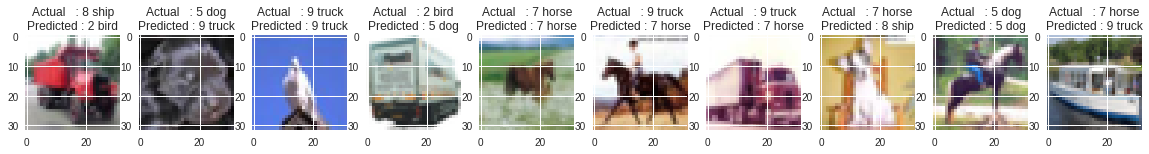

In [29]:
visualize(model1, rnd_img_data)

### Model 2

['5 dog', '9 truck', '9 truck', '7 horse', '7 horse', '9 truck', '5 dog', '2 bird', '7 horse', '8 ship']


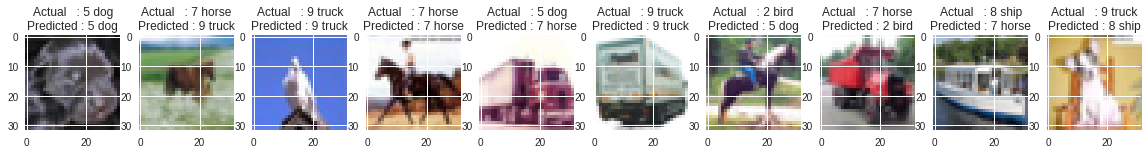

In [30]:
visualize(model2, rnd_img_data)